In [1]:
import pandas as pd

path_raw = "../data/raw/NBA_game_logs.csv"
df_raw = pd.read_csv(path_raw)

print("Shape:", df_raw.shape)
print("First 20 columns:", df_raw.columns.tolist()[:20])
df_raw.head()

Shape: (274771, 37)
First 20 columns: ['Rk', 'G', 'Date', 'Age', 'Tm', 'Location', 'Opp', 'W/L', 'W/L_margin', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB']


,Rk,G,Date,Age,Tm,Location,Opp,W/L,W/L_margin,MP,...,PTS,GmSc,+/-,Player,DOB,Series,G#,Years_pro,Draft_year,Season
0,1,1,10/27/2009,24.824658,CLE,NaN,BOS,L,-6,0 days 00:44:55.000000000,...,38,31.2,0.0,lebron-james,12/30/1984,NaN,NaN,5.998754,2003,2009
1,2,2,10/28/2009,24.827397,CLE,@,TOR,L,-10,0 days 00:39:47.000000000,...,23,20.2,2.0,lebron-james,12/30/1984,NaN,NaN,6.001492,2003,2009
2,3,3,10/30/2009,24.832877,CLE,@,MIN,W,17,0 days 00:33:26.000000000,...,24,22.0,17.0,lebron-james,12/30/1984,NaN,NaN,6.006968,2003,2009
3,4,4,10/31/2009,24.835616,CLE,NaN,CHA,W,11,0 days 00:37:14.000000000,...,14,11.9,19.0,lebron-james,12/30/1984,NaN,NaN,6.009706,2003,2009
4,5,5,11/3/2009,24.843836,CLE,NaN,WAS,W,12,0 days 00:35:59.000000000,...,27,24.6,5.0,lebron-james,12/30/1984,NaN,NaN,6.017920,2003,2009


In [2]:
import os
os.makedirs("../data/processed", exist_ok=True)

In [3]:
# Sauvegarde d'une première version processed (sans transformation)
path_processed = "../data/processed/NBA_game_logs_processed.csv"

df_raw.to_csv(path_processed, index=False)

print("Saved to:", path_processed)

Saved to: ../data/processed/NBA_game_logs_processed.csv


In [4]:

TRAIN_SEASONS = [2016, 2017, 2018, 2019]
TEST_SEASON = 2020

# 1) Garder uniquement les saisons utiles
df_raw = df_raw[df_raw["Season"].isin(TRAIN_SEASONS + [TEST_SEASON])].copy()

# 2) Créer la colonne train / test
df_raw["set"] = "train"
df_raw.loc[df_raw["Season"] == TEST_SEASON, "set"] = "test"

# 3) Vérifications (rapides et légères)
print("Observations par set:")
print(df_raw["set"].value_counts())

print("\nSaisons dans le train:", sorted(df_raw[df_raw["set"] == "train"]["Season"].unique()))
print("Saisons dans le test :", sorted(df_raw[df_raw["set"] == "test"]["Season"].unique()))

Observations par set:
set
train    88391
test      3814
Name: count, dtype: int64

Saisons dans le train: [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019)]
Saisons dans le test : [np.int64(2020)]


In [5]:
import numpy as np
import pandas as pd

# Conversion robuste de MP -> minutes
def mp_to_minutes(x):
    if pd.isna(x):
        return np.nan

    # essaie de parser en timedelta (ex: "0 days 00:44:55.000000000")
    try:
        td = pd.to_timedelta(x)
        return td.total_seconds() / 60
    except:
        pass

    # fallback si jamais c'est "mm:ss"
    if isinstance(x, str):
        x = x.strip()
        if ":" in x and "day" not in x:
            try:
                m, s = x.split(":")
                return float(m) + float(s) / 60
            except:
                return np.nan

    # fallback si déjà numérique
    try:
        return float(x)
    except:
        return np.nan


df_raw["MP_min"] = df_raw["MP"].apply(mp_to_minutes)

# check rapide
print(df_raw["MP"].head(3).tolist())
print(df_raw["MP_min"].head(3).tolist())

# Filtre >= 5 minutes
df_filt = df_raw[df_raw["MP_min"] >= 5].copy()

print("Matchs avant filtre :", len(df_raw))
print("Matchs après filtre  :", len(df_filt))


['0 days 00:41:12.000000000', '0 days 00:37:25.000000000', '0 days 00:31:12.000000000']
[41.2, 37.416666666666664, 31.2]
Matchs avant filtre : 92205
Matchs après filtre  : 86941


In [6]:
# Nombre de matchs par joueur / saison
games_per_season = (
    df_filt
    .groupby(["Player", "DOB", "Season"])
    .size()
    .reset_index(name="games_played")
)

# On garde seulement joueur-saison avec >= 40 matchs
eligible_player_seasons = games_per_season[
    games_per_season["games_played"] >= 40
]

# Merge pour filtrer la data principale
df_consistent = df_filt.merge(
    eligible_player_seasons[["Player", "DOB", "Season"]],
    on=["Player", "DOB", "Season"],
    how="inner"
)

print("Matchs après filtre 5 min :", len(df_filt))
print("Matchs après filtre ≥40 matchs/saison :", len(df_consistent))

print("\nExemple de saisons supprimées :")
print(
    games_per_season
    .sort_values("games_played")
    .head(10)
)

Matchs après filtre 5 min : 86941
Matchs après filtre ≥40 matchs/saison : 74786

Exemple de saisons supprimées :
                    Player         DOB  Season  games_played
94        anžejs-pasečņiks  12/20/1995    2020             1
868            jeremy-lamb   5/30/1992    2020             1
814       jarrell-brantley    6/7/1996    2020             1
808         jarnell-stokes    1/7/1994    2016             1
984             josh-smith   12/5/1985    2017             1
841          jaylen-nowell    7/9/1999    2020             1
863           jeremy-evans  10/24/1987    2017             1
1108  kostas-antetokounmpo  11/20/1997    2019             1
754        jahmi'us-ramsey    6/9/2001    2020             1
1059      kendrick-perkins  11/10/1984    2017             1


In [7]:
import numpy as np
import pandas as pd

df_work = df_consistent.copy()
print("Lignes df_work =", len(df_work))
print("Colonnes clés présentes ?", {"MP_min","GmSc","Season","Player","DOB"}.issubset(df_work.columns))

# 1) player_id (anti-homonymes)
df_work["DOB"] = pd.to_datetime(df_work["DOB"], errors="coerce")
df_work["player_id"] = df_work["Player"].astype(str).str.strip() + "_" + df_work["DOB"].dt.strftime("%Y-%m-%d")

# 2) GmSc per-36 (benchmark)
df_work["GmSc"] = pd.to_numeric(df_work["GmSc"], errors="coerce")
df_work["GmSc_36"] = df_work["GmSc"] * (36.0 / df_work["MP_min"])

# 3) Volatility (écart-type intra-saison) sur GmSc_36
vol_gmsc = (
    df_work.groupby(["player_id", "Season"])["GmSc_36"]
    .std(ddof=0)
    .reset_index(name="vol_GmSc_36")
)

print("Nb player-seasons =", len(vol_gmsc))
vol_gmsc.head()

Lignes df_work = 74786
Colonnes clés présentes ? True
Nb player-seasons = 1074


,player_id,Season,vol_GmSc_36
0,aaron-brooks_1985-01-14,2016,8.593401
1,aaron-gordon_1995-09-16,2016,7.214179
2,aaron-gordon_1995-09-16,2017,7.780545
3,aaron-gordon_1995-09-16,2018,6.552910
4,aaron-gordon_1995-09-16,2019,6.943935


In [8]:
import pandas as pd
import numpy as np

needed = ["PTS","AST","ORB","TOV","FG","FGA","FT","FTA","STL","BLK","DRB","PF"]
missing = [c for c in needed if c not in df_work.columns]
if missing:
    raise ValueError(f"Colonnes manquantes : {missing}")

for c in needed:
    df_work[c] = pd.to_numeric(df_work[c], errors="coerce")

# NOI (offensif) + ORB
df_work["NOI"] = (
    df_work["PTS"]
    + 1.5 * df_work["AST"]
    + 0.7 * df_work["ORB"]
    - 1.25 * df_work["TOV"]
    - 0.75 * (df_work["FGA"] - df_work["FG"])
    - 0.5  * (df_work["FTA"] - df_work["FT"])
)

# NDI (défensif)
df_work["NDI"] = (
    1.2 * df_work["STL"]
    + 1.0 * df_work["BLK"]
    + 0.8 * df_work["DRB"]
    - 0.6 * df_work["PF"]
)

df_work[["player_id","Season","NOI","NDI"]].head()

,player_id,Season,NOI,NDI
0,lebron-james_1984-12-30,2017,32.95,12.2
1,lebron-james_1984-12-30,2017,25.95,4.2
2,lebron-james_1984-12-30,2017,18.00,5.4
3,lebron-james_1984-12-30,2017,45.25,4.6
4,lebron-james_1984-12-30,2017,31.20,10.6


In [9]:
# Net Impact
df_work["Net_Impact"] = df_work["NOI"] - df_work["NDI"]

# Per-36 minutes
df_work["Net_Impact_36"] = df_work["Net_Impact"] * 36 / df_work["MP_min"]

# Nettoyage
df_work = df_work.replace([np.inf, -np.inf], np.nan)
df_work = df_work.dropna(subset=["Net_Impact_36"])

In [10]:
# ================================
# Volatilité Net Impact (player-season)
# ================================

vol_net = (
    df_work
    .groupby(["player_id", "Season"])
    .agg(
        net_mean=("Net_Impact_36", "mean"),
        net_volatility=("Net_Impact_36", "std"),
        games_played=("Net_Impact_36", "size"),
        minutes_avg=("MP_min", "mean")
    )
    .reset_index()
)

print("Nombre player-seasons :", len(vol_net))
vol_net.head()

Nombre player-seasons : 1074


,player_id,Season,net_mean,net_volatility,games_played,minutes_avg
0,aaron-brooks_1985-01-14,2016,10.592469,10.338888,62,14.411290
1,aaron-gordon_1995-09-16,2016,8.811878,8.230000,80,28.725000
2,aaron-gordon_1995-09-16,2017,7.549279,8.676377,58,32.911494
3,aaron-gordon_1995-09-16,2018,9.675575,8.143050,83,33.690964
4,aaron-gordon_1995-09-16,2019,8.684082,9.172941,62,32.534677


In [11]:
# ================================
# Relative volatility (main target)
# ================================

# Eviter divisions instables quand la moyenne est proche de 0
EPS = 1e-6

vol_net["relative_volatility"] = (
    vol_net["net_volatility"] /
    (vol_net["net_mean"].abs() + EPS)
)

# Sanity check
vol_net[[
    "player_id",
    "Season",
    "net_mean",
    "net_volatility",
    "relative_volatility"
]].head()

,player_id,Season,net_mean,net_volatility,relative_volatility
0,aaron-brooks_1985-01-14,2016,10.592469,10.338888,0.976060
1,aaron-gordon_1995-09-16,2016,8.811878,8.230000,0.933967
2,aaron-gordon_1995-09-16,2017,7.549279,8.676377,1.149299
3,aaron-gordon_1995-09-16,2018,9.675575,8.143050,0.841609
4,aaron-gordon_1995-09-16,2019,8.684082,9.172941,1.056294


In [12]:
validation_df = vol_net.merge(
    vol_gmsc,
    on=["player_id", "Season"],
    how="inner"
)

print("Nb player-seasons :", len(validation_df))
validation_df.head()

Nb player-seasons : 1074


,player_id,Season,net_mean,net_volatility,games_played,minutes_avg,relative_volatility,vol_GmSc_36
0,aaron-brooks_1985-01-14,2016,10.592469,10.338888,62,14.411290,0.976060,8.593401
1,aaron-gordon_1995-09-16,2016,8.811878,8.230000,80,28.725000,0.933967,7.214179
2,aaron-gordon_1995-09-16,2017,7.549279,8.676377,58,32.911494,1.149299,7.780545
3,aaron-gordon_1995-09-16,2018,9.675575,8.143050,83,33.690964,0.841609,6.552910
4,aaron-gordon_1995-09-16,2019,8.684082,9.172941,62,32.534677,1.056294,6.943935


In [13]:
plot_df = validation_df.copy()

# seuils visuels (quantiles, PAS arbitraires)
x_max = plot_df["vol_GmSc_36"].quantile(0.99)
y_max = plot_df["relative_volatility"].quantile(0.99)

plot_df["rv_clip"] = plot_df["relative_volatility"].clip(upper=y_max)
plot_df["gmsc_clip"] = plot_df["vol_GmSc_36"].clip(upper=x_max)

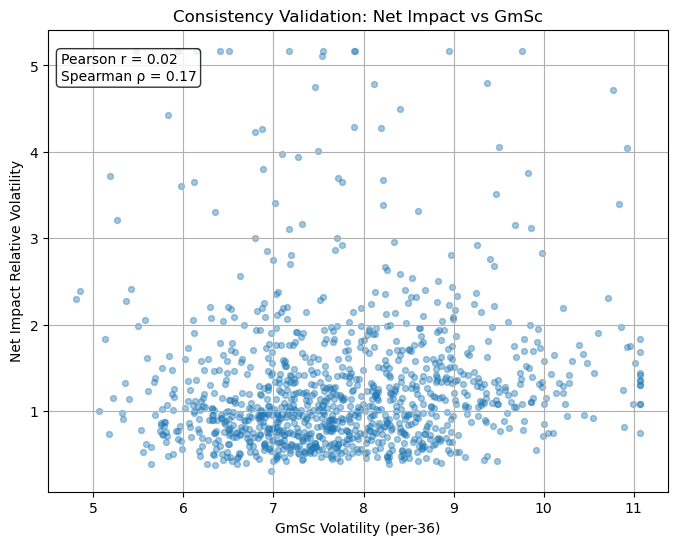

In [14]:
import matplotlib.pyplot as plt

corr_p = plot_df["vol_GmSc_36"].corr(plot_df["relative_volatility"], method="pearson")
corr_s = plot_df["vol_GmSc_36"].corr(plot_df["relative_volatility"], method="spearman")

plt.figure(figsize=(8, 6))

plt.scatter(
    plot_df["gmsc_clip"],
    plot_df["rv_clip"],
    alpha=0.4,
    s=18
)

plt.xlabel("GmSc Volatility (per-36)")
plt.ylabel("Net Impact Relative Volatility")
plt.title("Consistency Validation: Net Impact vs GmSc")

plt.text(
    0.02, 0.95,
    f"Pearson r = {corr_p:.2f}\nSpearman ρ = {corr_s:.2f}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.grid(True)
plt.show()